<h1> Sound Classification

<h2> using the urban sound dataset:</h2>

about 6,000 sound excerpts in ten different "classes"
- Air Conditioner
- Car Horn
- Children Playing
- Dog bark
- Drilling
- Engine Idling
- Gun Shot
- Jackhammer
- Siren
- Street Music

<h2> can we build a neural network that can predict the kind of sound based on frequency patterns in the data?


In [2]:
import glob
import os
import librosa
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from matplotlib.pyplot import specgram
%matplotlib inline

<h3> what does it mean for a sound file to have patterns?

we're using **librosa**, an awesome python library, to load and then extract features from our wav files

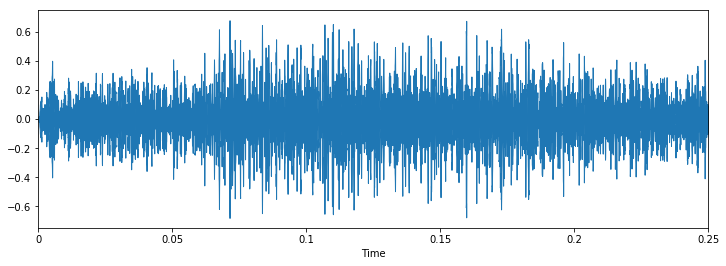

In [3]:
import librosa.display
data, sample_rate = librosa.core.load("./sound-data/Train/4934.wav")
plt.figure(figsize=(12,4))

librosa.display.waveplot(data,sr=sample_rate)

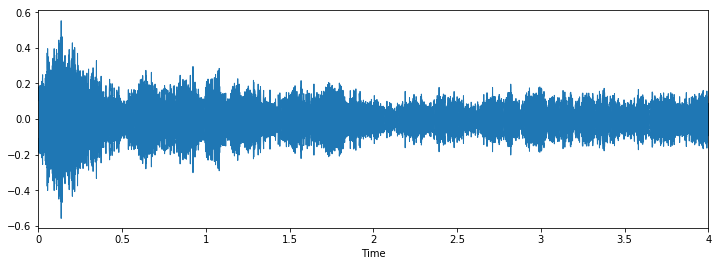

In [4]:
data, sample_rate = librosa.core.load("./sound-data/Train/3735.wav")
plt.figure(figsize=(12,4))

librosa.display.waveplot(data,sr=sample_rate)

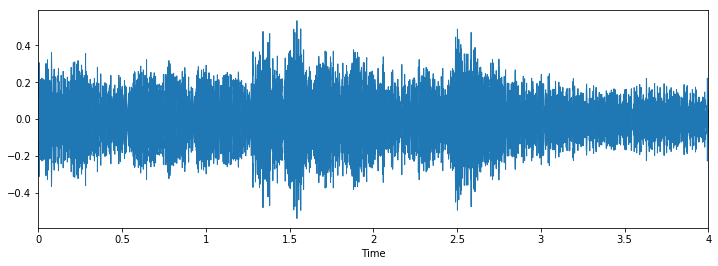

In [5]:
data, sample_rate = librosa.core.load("./sound-data/Train/1174.wav")
plt.figure(figsize=(12,4))

librosa.display.waveplot(data,sr=sample_rate)

<h3> what do our files sound like?

In [6]:
import IPython.display as ipd

ipd.Audio('./sound-data/Train/4138.wav')

In [7]:
import pandas as pd
train = pd.read_csv('./train.csv')

In [8]:
train.Class.value_counts() #check distribution of data

jackhammer          668
engine_idling       624
siren               607
dog_bark            600
air_conditioner     600
children_playing    600
street_music        600
drilling            600
car_horn            306
gun_shot            230
Name: Class, dtype: int64

In [9]:
train.tail()

,ID,Class
5430,8725,engine_idling
5431,8726,dog_bark
5432,8727,engine_idling
5433,8728,engine_idling
5434,8729,air_conditioner


<h2> parse audio data (from .wav files) and extract a new featureset 
*(mel-frequency cepstrum)*

In [10]:
def parser(row):
    file_name = os.path.join(os.path.abspath('./sound-data/Train/'),str(row.ID)+'.wav')
    try:
        X,sample_rate = librosa.load(file_name,res_type='kaiser_fast')
        mfccs = np.mean(librosa.feature.mfcc(y=X,sr=sample_rate,n_mfcc=40).T,axis=0)
    except Exception as e:
        #print('Error encountered while parsing the file:',file_name)
        pbar.update()
        return pd.Series(np.repeat(np.nan, 41))
    
    feature = mfccs  
    label = row.Class
   
    if len(feature) != 40:
        feature = np.repeat(np.nan, 40)
    final = pd.Series(list(feature)+[label])
    assert len(final) == 41, f'length: {len(final)}'
    pbar.update()
    #raise Exception
    return final

In [11]:
from tqdm import tqdm_notebook as tqdm
pbar = tqdm(range(len(train)))
temp = train.apply(parser,axis =1);
pbar.close()

In [12]:
temp.shape

(5435, 41)

In [13]:
print(temp.dropna().shape)
temp.tail()

(3670, 41)


,0,1,2,3,4,5,6,7,8,9,...,31,32,33,34,35,36,37,38,39,40
5430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5431,-395.345895,105.813360,-0.196292,-7.097909,-15.923747,5.508246,-15.960885,2.319544,-12.581349,-1.546713,...,2.966827,1.177062,0.974650,-0.202372,3.193910,0.338809,-2.099853,-0.137884,0.226945,dog_bark
5432,-320.817402,58.300552,-6.869504,15.693744,-0.609614,35.342088,-12.227011,8.644004,-14.346959,9.430050,...,-6.078462,-8.514474,-3.328231,-5.746517,1.185591,-5.073384,0.927267,-4.828223,2.273388,engine_idling
5433,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5434,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<h3> format and split data for training

In [14]:
temp = temp[temp.iloc[:,-1].notnull()]

In [15]:
X = temp.iloc[:,0:40]
y = temp.iloc[:,-1]

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.1, random_state = 42)

In [17]:
from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

le = LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
#y_train = np_utils.to_categorical(y_train)

Using TensorFlow backend.


In [18]:
y_train.shape

(3303,)

<h2> build a simple neural network model

In [24]:
from keras import models
from keras import layers
from keras.layers import Dropout

inputs = layers.Input(shape=(40,))

hidden_1 = layers.Dense(units=128, activation='relu')(inputs)
Dropout(0.5)(hidden_1)
hidden_2 = layers.Dense(units=128, activation='relu')(hidden_1)
Dropout(0.5)(hidden_2)
hidden_3 = layers.Dense(units=64, activation='relu')(hidden_2)
Dropout(0.5)(hidden_3)

preds = layers.Dense(10, activation='softmax')(hidden_2)

In [25]:
network = models.Model(inputs=inputs, outputs=preds)

network.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 40)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 128)               5248      
_________________________________________________________________
dense_6 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_8 (Dense)              (None, 10)                1290      
Total params: 23,050
Trainable params: 23,050
Non-trainable params: 0
_________________________________________________________________


In [26]:
from keras import optimizers

network.compile(optimizer=optimizers.Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [27]:
network.fit(x=X_train, y=y_train, batch_size=80, epochs=10)

Epoch 1/10
3303/3303 [==============================] - 0s 87us/step - loss: 7.6113 - acc: 0.2610
Epoch 2/10
3303/3303 [==============================] - 0s 19us/step - loss: 3.8669 - acc: 0.4223
Epoch 3/10
3303/3303 [==============================] - 0s 20us/step - loss: 2.1281 - acc: 0.5216
Epoch 4/10
3303/3303 [==============================] - 0s 19us/step - loss: 1.3801 - acc: 0.6085
Epoch 5/10
3303/3303 [==============================] - 0s 20us/step - loss: 1.1035 - acc: 0.6649
Epoch 6/10
3303/3303 [==============================] - 0s 20us/step - loss: 0.9604 - acc: 0.7124
Epoch 7/10
3303/3303 [==============================] - 0s 21us/step - loss: 0.8579 - acc: 0.7296
Epoch 8/10
3303/3303 [==============================] - 0s 20us/step - loss: 0.8529 - acc: 0.7339
Epoch 9/10
3303/3303 [==============================] - 0s 19us/step - loss: 0.7285 - acc: 0.7763
Epoch 10/10
3303/3303 [==============================] - 0s 20us/step - loss: 0.7266 - acc: 0.7699


<h2> run model on test data

In [28]:
test_loss, test_acc = network.evaluate(X_test, y_test)
test_acc

367/367 [==============================] - 0s 126us/step


0.7629427801036055